# ZOD Dataset Exploration - Camera-Specific Pedestrian Prediction



In [1]:
from pathlib import Path # for file path operations
import os # for file path operations
from PIL import Image # for image processing
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import json
import numpy as np
import pandas as pd
#import seaborn as sns
import torch
import torchvision
from collections import Counter
import cv2
import random
from collections import defaultdict
import matplotlib.patches as patches
from math import sqrt



#### Establish paths to ZOD frames (original and ZOD256):

In [6]:
# This is the path to the ZOD256 dataset on the VM
# Its the ZOD dataset, cropped and resized it to 256x256. 
ZOD256_ROOT = Path("/mnt/pr_2018_scaleout_workdir/ZOD256/single_frames/")
# Path to original ZOD frames
ORIGINAL_ZOD_ROOT = Path("/home/edgelab/zod_dino_data/train2017/")
print("ZOD256_ROOT exists:", ZOD256_ROOT.exists())
print("ORIGINAL_ZOD_ROOT exists:", ORIGINAL_ZOD_ROOT.exists())




ZOD256_ROOT exists: True
ORIGINAL_ZOD_ROOT exists: True


## Dataset location and on-disk structure (local VM)

**Dataset root:** `/mnt/pr_2018_scaleout_workdir/ZOD256`

We will work with: 
- `single_frames` folder

### Frame folder structure, 100000 single frame directories:
`000000/`, ... , `099999/`

Each frame folder contains:
- `annotations/` — per-frame labels (e.g., 2D/3D boxes, segmentation, etc.)
- `camera_front_blur/` — anonymized camera image (blur)
- `camera_front_dnat/` — anonymized camera image (DNAT)
- `lidar_velodyne/` — LiDAR data for the keyframe

This exploration notebook focuses on **vision-only** using the front camera images
(`camera_front_blur` / `camera_front_dnat`) and the corresponding object labels
in `annotations/`, with emphasis on **pedestrians** and condition metadata.


### We will now compare the ZOD256 images with the original ones (images + annotations):

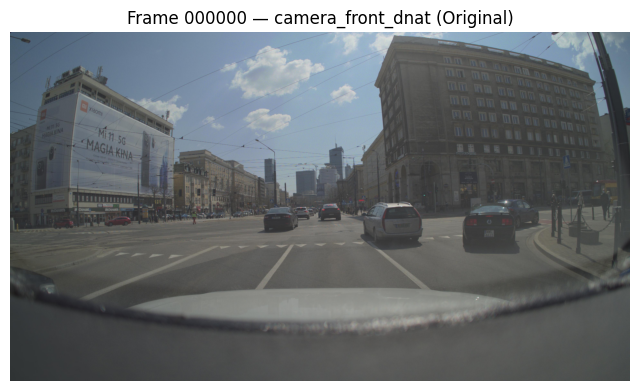

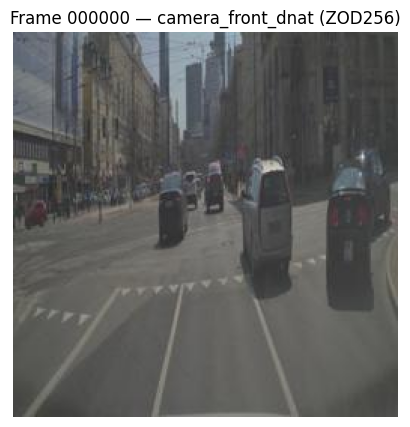

Original image size (W,H): (3848, 2168)
ZOD256 image size (W,H): (256, 256)


In [7]:
frame_id = "000000" # we look at the first frame in both datasets
# Now some visualization of the DNAT images in the two datasets:
ZOD256_first_frame_dir = ZOD256_ROOT / frame_id
ORIGINAL_first_frame_dir = ORIGINAL_ZOD_ROOT / frame_id
ZOD256_DNAT_DIR = ZOD256_first_frame_dir / "camera_front_dnat"
ORIGINAL_DNAT_DIR = ORIGINAL_first_frame_dir / "camera_front_dnat"

# Find the actual image files in these directories
zod256_dnat_files = list(ZOD256_DNAT_DIR.glob("*.jpg"))
original_dnat_files = list(ORIGINAL_DNAT_DIR.glob("*.jpg"))

# Check if files exist before trying to open them
if not zod256_dnat_files:
    raise FileNotFoundError(f"No .jpg files found in {ZOD256_DNAT_DIR}")
if not original_dnat_files:
    raise FileNotFoundError(f"No .jpg files found in {ORIGINAL_DNAT_DIR}")

# Read DNAT images (use the first file found)
ZOD256_DNAT_IMG = Image.open(zod256_dnat_files[0])
ORIGINAL_DNAT_IMG = Image.open(original_dnat_files[0])

# Display DNAT images
# Original DNAT image
plt.figure(figsize=(8, 5))
plt.imshow(ORIGINAL_DNAT_IMG)
plt.axis("off")
plt.title(f"Frame {frame_id} — camera_front_dnat (Original)")
plt.show()

# ZOD256 DNAT image
plt.figure(figsize=(8, 5))
plt.imshow(ZOD256_DNAT_IMG)
plt.axis("off")
plt.title(f"Frame {frame_id} — camera_front_dnat (ZOD256)")
plt.show()

# Image sizes pre/post resize:
print("Original image size (W,H):", ORIGINAL_DNAT_IMG.size)
print("ZOD256 image size (W,H):", ZOD256_DNAT_IMG.size)

### Visualize the crop region on the original image

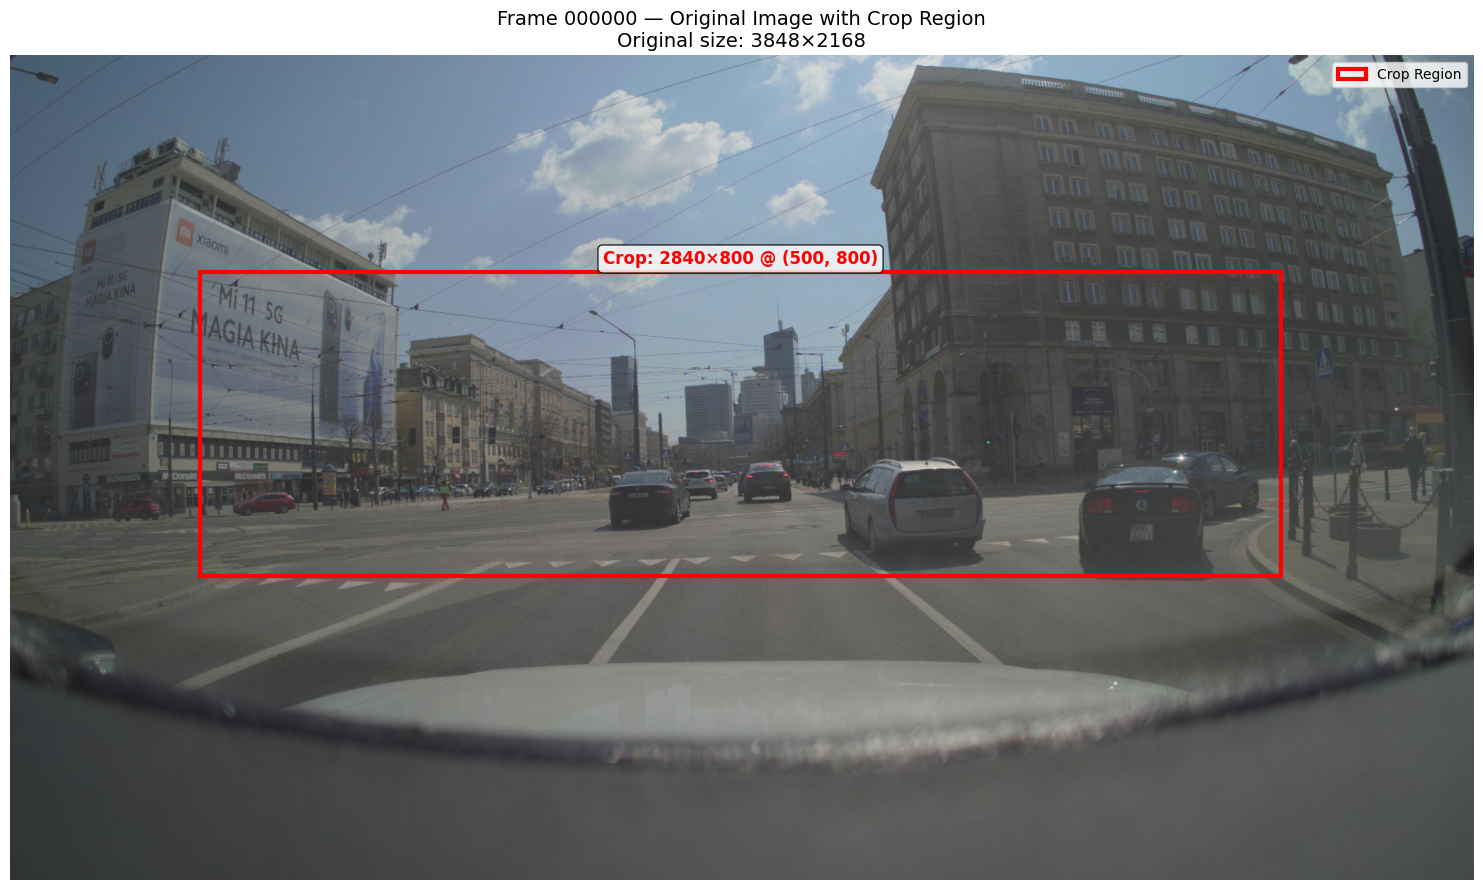

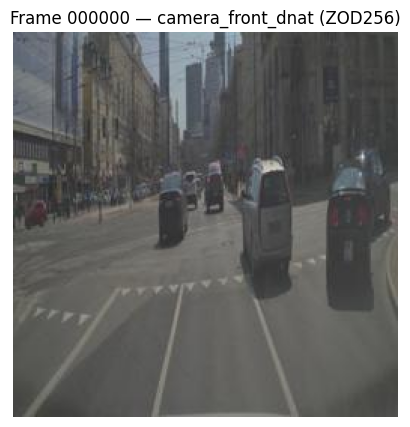

Crop region: left=500, top=800, width=2840, height=800
Crop region in original coordinates: (500, 800) to (3340, 1600)
Original image size: 3848×2168
Cropped region size: 2840×800
After resize to 256×256: 256×256


In [ ]:
# Visualize the crop region on the original image
# Crop rectangle parameters (in original image coordinates):
#x-coordinate where the crop starts
crop_left = 500
#y-coordinate where the crop starts
crop_top = 800
#width of the crop
crop_width = 2840
#height of the crop
crop_height = 800

# Load the original image
frame_id = "000000"
ORIGINAL_first_frame_dir = ORIGINAL_ZOD_ROOT / frame_id
ORIGINAL_DNAT_DIR = ORIGINAL_first_frame_dir / "camera_front_dnat"
original_dnat_files = list(ORIGINAL_DNAT_DIR.glob("*.jpg"))
original_img = Image.open(original_dnat_files[0])

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

# Display the original image
ax.imshow(original_img)

# Create rectangle patch for the crop region
# Rectangle parameters: (left, bottom, width, height)
# Note: matplotlib uses bottom-left corner, but images use top-left
# So we need: (left, top from bottom, width, height)
# top from bottom = image_height - top - height
img_height = original_img.size[1]  # PIL uses (width, height)
rect_bottom = img_height - crop_top - crop_height

crop_rect = patches.Rectangle(
    (crop_left, rect_bottom),
    crop_width,
    crop_height,
    linewidth=3,
    edgecolor='red',
    facecolor='none',
    label='Crop Region'
)

ax.add_patch(crop_rect)

# Add text annotation
ax.text(
    crop_left + crop_width/2,
    rect_bottom - 20,
    f'Crop: {crop_width}×{crop_height} @ ({crop_left}, {crop_top})',
    color='red',
    fontsize=12,
    weight='bold',
    ha='center',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

ax.set_title(f"Frame {frame_id} — Original Image with Crop Region\nOriginal size: {original_img.size[0]}×{original_img.size[1]}", fontsize=14)
ax.axis("off")
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

# ZOD256 DNAT image
plt.figure(figsize=(8, 5))
plt.imshow(ZOD256_DNAT_IMG)
plt.axis("off")
plt.title(f"Frame {frame_id} — camera_front_dnat (ZOD256)")
plt.show()

print(f"Crop region: left={crop_left}, top={crop_top}, width={crop_width}, height={crop_height}")
print(f"Crop region in original coordinates: ({crop_left}, {crop_top}) to ({crop_left + crop_width}, {crop_top + crop_height})")
print(f"Original image size: {original_img.size[0]}×{original_img.size[1]}")
print(f"Cropped region size: {crop_width}×{crop_height}")
print(f"After resize to 256×256: 256×256")

# Display the cropped image resized to 1024×256
crop_box = (crop_left, crop_top, crop_left + crop_width, crop_top + crop_height)
cropped_img = original_img.crop(crop_box)
cropped_resized = cropped_img.resize((1024, 256), resample=Image.BILINEAR)

plt.figure(figsize=(12, 3))
plt.imshow(cropped_resized)
plt.title(f"Frame {frame_id} — Cropped and resized to 1024×256")
plt.axis("off")
plt.show()



*Challenges*: 
- **Image Quality and object sizes**: It is no surprise that image quality is significantly worse in the ZOD256 dataset and pedestrians much harder to identify with the blind eye. This could provide a significant challenge for pedestrian prediction. 
- **Cropped images**: We see that quite a significant amount of the original image is cropped out, and we even observe that three pedestrians are excluded on the RHS. This provides another challenge, as we must ensure that annotations (pedestrian metadata) are appropriately modified to account for this crop. Pedestrian counts per image will differ, for example. 
- **Wrong crop**: We notice that the crop used in ZOD256 is not actually identical to that provided in the script provided by Jonas. Thus, perhaps the best option is to create a dataset from scratch and do the crop / resize ourselves. 

Hence: 
- Pedestrians are left out of crop --> must adjust count annotations along with bounding boxes.
- **ZOD256 preprocessing is undocumented and we therefore must pivot and instead create our own dataset from scratch and appropriately update all metadata.**

#### We analyze frame-specific json files:

In [9]:

def read_json(path: Path):
    """
    Read a JSON file from disk and return it as a Python object.
    Parameters:
    - path: Path object pointing to a .json file
    Returns:
    - A Python dictionary or list (depending on the JSON content)
    """
    # first we open the file in read mode
    with open(path, "r") as file:

        # json.load reads JSON-formatted text from the file object 'file'
        # and converts it into native Python objects (dicts, lists, etc.)
        data = json.load(file)

    return data

# Read metadata describing environment conditions
ZOD256_first_frame_metadata = read_json(ZOD256_first_frame_dir / "metadata.json")
ORIGINAL_first_frame_metadata = read_json(ORIGINAL_first_frame_dir / "metadata.json")
#print(metadata)

# Read general info about the frame
ZOD256_first_frame_info = read_json(ZOD256_first_frame_dir / "info.json")
ORIGINAL_first_frame_info = read_json(ORIGINAL_first_frame_dir / "info.json")
#print(ZOD256_first_frame_info)
#print(ORIGINAL_first_frame_info)

print("metadata.json 000000 (keys: values)")
for k in ZOD256_first_frame_metadata.keys():
    print(f" - {k}: ZOD256={ZOD256_first_frame_metadata[k]}, ORIGINAL={ORIGINAL_first_frame_metadata[k]}")




metadata.json 000000 (keys: values)
 - frame_id: ZOD256=000000, ORIGINAL=000000
 - time: ZOD256=2021-04-19T10:23:10.444124Z, ORIGINAL=2021-04-19T10:23:10.444124Z
 - country_code: ZOD256=PL, ORIGINAL=PL
 - scraped_weather: ZOD256=partly-cloudy-day, ORIGINAL=partly-cloudy-day
 - collection_car: ZOD256=india, ORIGINAL=india
 - road_type: ZOD256=city, ORIGINAL=city
 - road_condition: ZOD256=normal, ORIGINAL=normal
 - time_of_day: ZOD256=day, ORIGINAL=day
 - num_lane_instances: ZOD256=21, ORIGINAL=21
 - num_vehicles: ZOD256=36, ORIGINAL=36
 - num_vulnerable_vehicles: ZOD256=5, ORIGINAL=5
 - num_pedestrians: ZOD256=40, ORIGINAL=40
 - num_traffic_lights: ZOD256=37, ORIGINAL=37
 - num_traffic_signs: ZOD256=35, ORIGINAL=35
 - longitude: ZOD256=20.993243252850032, ORIGINAL=20.993243252850032
 - latitude: ZOD256=52.24205173254378, ORIGINAL=52.24205173254378
 - solar_angle_elevation: ZOD256=49.17233721956617, ORIGINAL=49.17233721956617


#### We see that the metadata has not been adjusted at all despite the crop. 

- This is only problematic for fields with a count such as num_vehicles and num_pedestrians. That's okay for our purposes, since we will rely on *annotations/object_detection.json* for pedestrian counts instead. We will however check for consistency in count data across metadata.json / object_detection.json. 

- Note that info.json is a file with a bunch of file paths, which we will not use. 

### Annotations
Each annotation is referenced via a relative filepath under:
single_frames/000000/annotations/

- Object detection
- Lane markings
- Traffic signs
- Road condition


### LiDAR frames
- Sequence of Velodyne LiDAR scans at ~10 Hz
- Covers approximately ±1 second around the keyframe
- Stored as .npy point clouds
- All scans marked is_compensated: False


# object_detection.json

In [10]:
# Object detection annotations live inside the frame folder
ZOD256_obj_det_path = ZOD256_first_frame_dir / "annotations" / "object_detection.json"
ORIGINAL_obj_det_path = ORIGINAL_first_frame_dir / "annotations" / "object_detection.json"
print(ZOD256_obj_det_path.exists())
print(ORIGINAL_obj_det_path.exists())


# Reuse our existing helper (no need to re-write open/json.load every time)
# obj_det contents are lists of dictionaries, containing the annotations for each object in the frame.
ZOD256_obj_det = read_json(ZOD256_obj_det_path)
print(f"ZOD256_obj_det[0]: {ZOD256_obj_det[0]}")
ORIGINAL_obj_det = read_json(ORIGINAL_obj_det_path)
print(f"ORIGINAL_obj_det[0]: {ORIGINAL_obj_det[0]}")

# type and size of obj_det contents
print("Type of obj_det:", type(ZOD256_obj_det))
print("Number of objects in this frame:", len(ZOD256_obj_det))
print("Type of obj_det:", type(ORIGINAL_obj_det))
print("Number of objects in this frame:", len(ORIGINAL_obj_det))



True
True
ZOD256_obj_det[0]: {'geometry': {'coordinates': [[1664.73, 1033.14], [1665.88, 1034.75], [1663.35, 1122.14], [1661.97, 1121.91]], 'type': 'MultiPoint'}, 'properties': {'annotation_uuid': '0007dce0-769f-4775-92ef-23f9173daa7d', 'class': 'PoleObject', 'is_for_construction': False, 'is_on_dynamic_object': False, 'occlusion_ratio': 'Medium', 'traffic_content_visible': 'Undefined', 'type': 'LampPole', 'unclear': False}}
ORIGINAL_obj_det[0]: {'geometry': {'coordinates': [[1664.73, 1033.14], [1665.88, 1034.75], [1663.35, 1122.14], [1661.97, 1121.91]], 'type': 'MultiPoint'}, 'properties': {'annotation_uuid': '0007dce0-769f-4775-92ef-23f9173daa7d', 'class': 'PoleObject', 'is_for_construction': False, 'is_on_dynamic_object': False, 'occlusion_ratio': 'Medium', 'traffic_content_visible': 'Undefined', 'type': 'LampPole', 'unclear': False}}
Type of obj_det: <class 'list'>
Number of objects in this frame: 281
Type of obj_det: <class 'list'>
Number of objects in this frame: 281


Object detection annotations have not been adjusted post-crop and resize. THis is highly problematic and must be dealt with. The bounding boxis are in in the original scale even on the resized dataset. 

*NEXT* we check weather counts have been adjusted for ZOD256 crop. 

In [11]:
ZOD256_classes = []
ZOD256_missing_class_count = 0

ORIGINAL_classes = []
ORIGINAL_missing_class_count = 0

for obj in ZOD256_obj_det:
    props = obj.get("properties", {})  
    cls = props.get("class", None)
    
    if cls is None:
        missing_class_count += 1
    else:
        ZOD256_classes.append(cls)

for obj in ORIGINAL_obj_det:
    props = obj.get("properties", {})  
    cls = props.get("class", None)
    
    if cls is None:
        ORIGINAL_missing_class_count += 1
    else:
        ORIGINAL_classes.append(cls)

print(f"Total objects in ZOD256 frame: {len(ZOD256_obj_det)}")
print(f"Objects missing properties['class']: {ZOD256_missing_class_count}")
print(f"Total objects in ORIGINAL frame: {len(ORIGINAL_obj_det)}")
print(f"Objects missing properties['class']: {ORIGINAL_missing_class_count}")


ZOD256_class_counts = Counter(ZOD256_classes)

print("\nZOD256 Class counts (most common first):")
for cls, cnt in ZOD256_class_counts.most_common():
    print(f"{cls:25s}  {cnt}")

ORIGINAL_class_counts = Counter(ORIGINAL_classes)
print(f"\nORIGINAL Class counts (most common first):")
for cls, cnt in ORIGINAL_class_counts.most_common():
    print(f"{cls:25s}  {cnt}")

print(f"\nNumber of unique classes in this frame: {len(ZOD256_class_counts)}")


Total objects in ZOD256 frame: 281
Objects missing properties['class']: 0
Total objects in ORIGINAL frame: 281
Objects missing properties['class']: 0

ZOD256 Class counts (most common first):
Pedestrian                 57
TrafficGuide               52
PoleObject                 49
Vehicle                    46
TrafficSignal              37
TrafficSign                35
VulnerableVehicle          5

ORIGINAL Class counts (most common first):
Pedestrian                 57
TrafficGuide               52
PoleObject                 49
Vehicle                    46
TrafficSignal              37
TrafficSign                35
VulnerableVehicle          5

Number of unique classes in this frame: 7


Findings:
- ZOD256 object counts have not been adjusted to account for the crop, we will have to do that ourselves.
- Metadata.json pedestrian count is 40 which doesn't match the 57 that we see for this frame in annotations/object_detection.json. The reason for this is that there are 17 pedestrian objects in annotations marked as "unclear", essentially low-quality annotations. Metadata.json only includes those marked as "clear" in its count.  

In [12]:
# we now analyze the first object in the list:
# ZOD256_obj_det is a list of dictionaries, each containing a geometry and properties dictionary. 
ZOD256_first_obj = ZOD256_obj_det[0]

print(ZOD256_first_obj.keys())

geometry = ZOD256_first_obj["geometry"]
properties = ZOD256_first_obj["properties"]
print(f"geometry: {geometry}")
print(f"properties: {properties}")

dict_keys(['geometry', 'properties'])
geometry: {'coordinates': [[1664.73, 1033.14], [1665.88, 1034.75], [1663.35, 1122.14], [1661.97, 1121.91]], 'type': 'MultiPoint'}
properties: {'annotation_uuid': '0007dce0-769f-4775-92ef-23f9173daa7d', 'class': 'PoleObject', 'is_for_construction': False, 'is_on_dynamic_object': False, 'occlusion_ratio': 'Medium', 'traffic_content_visible': 'Undefined', 'type': 'LampPole', 'unclear': False}


# Creating new ZOD256 dataset for camera-only baseline
- We'd ideally like to preserve ratio of dimentions since forcing a rectangle -> square yields pedestrian distortion which can make them look quite long and thin -- almost like poles. ZOD256 crops and resizes to increase pedestrian size which is important, but is heavily distorts pedestrian shapes. 
- We would also like to keep pedestrian size as large as possible. 
- We'd like to keep images as small as possible for reasonable computation time. 

Original image size (W,H): (3848, 2168)
Original resized to (W,H): (512, 288)
ZOD256 image size (W,H): (256, 256)


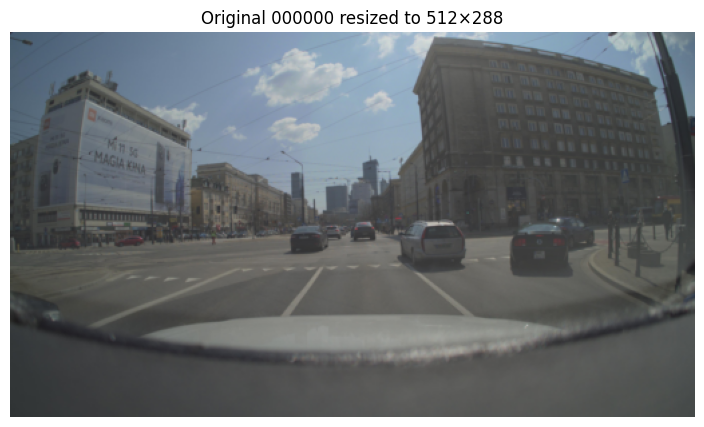

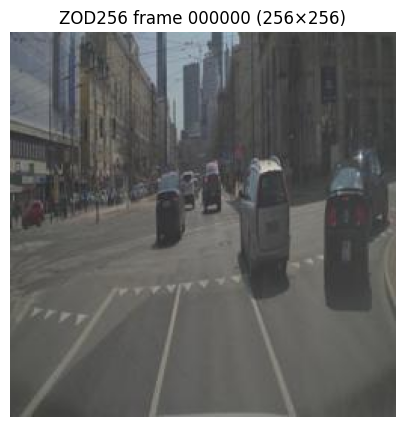

In [13]:
# FIRST WE VISUALIZE resize of original image to 512×288
# THis version requires modifying count annotations. 

# Original full-res image (frame 000000)
# Use the DNAT subfolder for the original image, same as above
orig_dnat_dir = ORIGINAL_first_frame_dir / "camera_front_dnat"
orig_img_path = sorted(orig_dnat_dir.glob("*.jpg"))[0]
orig_img = Image.open(orig_img_path).convert("RGB")

# Resize original to 512×288 (same aspect ratio, a bit larger)
orig_resized = orig_img.resize((512, 288), resample=Image.BILINEAR)

# ZOD256 image (frame 000000)
z256_frame_dir = ZOD256_ROOT / frame_id / "camera_front_dnat"
z256_img_path = sorted(z256_frame_dir.glob("*.jpg"))[0]
z256_img = Image.open(z256_img_path).convert("RGB")

print("Original image size (W,H):", orig_img.size)
print("Original resized to (W,H):", orig_resized.size)
print("ZOD256 image size (W,H):", z256_img.size)

# Show as two separate larger figures instead of small subplots
plt.figure(figsize=(10, 5))
plt.imshow(orig_resized)
plt.title("Original 000000 resized to 512×288")
plt.axis("off")
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(z256_img)
plt.title("ZOD256 frame 000000 (256×256)")
plt.axis("off")
plt.show()


### Pedestrian visibility feasibility analysis under global resize (no cropping, no annotation changes):

In [ ]:
# 1) Assume original image size
orig_W, orig_H = 3848, 2168

# C) limit number of frames for speed (None = all frames)
MAX_FRAMES = 5000  # e.g. set to 2000 for a fast approximate analysis

# E) Parquet caches for bbox widths/heights and per-frame medians (original scale)
box_cache_path = Path("outputs/analysis/ped_box_wh.parquet")
frame_medians_cache_path = Path("outputs/analysis/ped_frame_medians.parquet")
box_cache_path.parent.mkdir(parents=True, exist_ok=True)

if box_cache_path.exists():
    wh_df = pd.read_parquet(box_cache_path)
    ped_widths = wh_df["bbox_w"].to_numpy(dtype=np.float32)
    ped_heights = wh_df["bbox_h"].to_numpy(dtype=np.float32)

    if frame_medians_cache_path.exists():
        fm_df = pd.read_parquet(frame_medians_cache_path)
        frame_medians = fm_df["frame_median_h"].to_numpy(dtype=np.float32)
        print(
            f"Loaded cached bbox stats from {box_cache_path} and frame medians from {frame_medians_cache_path} "
            f"— {len(ped_heights)} pedestrians, {len(frame_medians)} frames with pedestrians."
        )
    else:
        frame_medians = None
        print(
            f"Loaded cached bbox stats from {box_cache_path} — {len(ped_heights)} pedestrians. "
            "No frame-median cache found; per-frame stats will be skipped."
        )
else:
    ped_widths = []
    ped_heights = []
    frame_medians = []  # store per-frame median heights (original scale)

    # 1) IMPORTANT PATH CLARITY: use ORIGINAL_ZOD_ROOT
    orig_frame_dirs = sorted([p for p in ORIGINAL_ZOD_ROOT.iterdir() if p.is_dir()])
    if MAX_FRAMES is not None:
        orig_frame_dirs = orig_frame_dirs[:MAX_FRAMES]
    print("Total original frame dirs considered:", len(orig_frame_dirs))

    warned_bad_obj = False
    inspected_schema = False
    printed_sample_schema = False
    total_frames_scanned = 0

    for frame_dir in orig_frame_dirs:
        # Confirm we are reading annotations from ORIGINAL dataset
        ann_path = frame_dir / "annotations" / "object_detection.json"
        if not ann_path.exists():
            continue

        total_frames_scanned += 1
        obj_det = read_json(ann_path)

        # 3) JSON list-key handling + schema inspection
        obj_list = None
        if isinstance(obj_det, dict):
            if not inspected_schema:
                print(f"Annotation dict keys for {ann_path}:", list(obj_det.keys()))
                inspected_schema = True
            if "objects" in obj_det and isinstance(obj_det["objects"], list):
                obj_list = obj_det["objects"]
            elif "annotations" in obj_det and isinstance(obj_det["annotations"], list):
                obj_list = obj_det["annotations"]

            if obj_list is not None and not printed_sample_schema and len(obj_list) > 0 and isinstance(obj_list[0], dict):
                print("Sample object keys under chosen list key:", list(obj_list[0].keys()))
                printed_sample_schema = True

            if obj_list is None:
                if not warned_bad_obj:
                    print(f"Warning: annotation dict in {ann_path} has no list key among 'objects'/'annotations'. Keys: {list(obj_det.keys())}")
                    warned_bad_obj = True
                continue
        elif isinstance(obj_det, list):
            obj_list = obj_det
            if not inspected_schema and len(obj_list) > 0 and isinstance(obj_list[0], dict):
                print(f"Annotation list sample object keys for {ann_path}:", list(obj_list[0].keys()))
                inspected_schema = True
        else:
            if not warned_bad_obj:
                print(f"Warning: annotation in {ann_path} is neither dict nor list (type={type(obj_det)}). Skipping.")
                warned_bad_obj = True
            continue

        frame_heights = []

        for obj in obj_list:
            # 4) Relax pre-filter: require only 'properties'
            if not isinstance(obj, dict):
                if not warned_bad_obj:
                    print("Warning: found non-dict object in annotations. Further warnings suppressed.")
                    warned_bad_obj = True
                continue

            if "properties" not in obj:
                continue

            props = obj.get("properties", {})
            if props.get("class") != "Pedestrian":
                continue

            # 5) Geometry-based width/height using MultiPoint coordinates
            w = h = None

            geom = obj.get("geometry", {})
            coords = geom.get("coordinates", []) if isinstance(geom, dict) else []

            # If coordinates are nested like [[[x,y], ...]] (MultiPoint nesting), flatten one level
            if (
                isinstance(coords, list)
                and len(coords) == 1
                and isinstance(coords[0], list)
                and len(coords[0]) > 0
                and isinstance(coords[0][0], (list, tuple))
            ):
                coords = coords[0]

            if not coords:
                continue

            # Robust guard: ensure coords is a list of [x, y] points
            valid_pts = []
            for pt in coords:
                if not (isinstance(pt, (list, tuple)) and len(pt) >= 2):
                    continue
                x, y = pt[0], pt[1]
                if not (isinstance(x, (int, float)) and isinstance(y, (int, float))):
                    continue
                valid_pts.append((x, y))

            if not valid_pts:
                continue

            xs = [p[0] for p in valid_pts]
            ys = [p[1] for p in valid_pts]
            w = max(xs) - min(xs)
            h = max(ys) - min(ys)

            # 3) Basic sanity filters
            if w is None or h is None:
                continue
            if w <= 0 or h <= 0:
                continue
            if w > orig_W or h > orig_H:
                continue
            if w < 2 or h < 2:
                continue

            ped_widths.append(w)
            ped_heights.append(h)
            frame_heights.append(h)

        if frame_heights:
            frame_medians.append(float(np.median(frame_heights)))

    ped_widths = np.array(ped_widths, dtype=np.float32)
    ped_heights = np.array(ped_heights, dtype=np.float32)
    frame_medians = np.array(frame_medians, dtype=np.float32)

    print("Frames scanned:", total_frames_scanned)
    print("Total pedestrian instances (original-scale):", len(ped_heights))
    print("Frames with at least one pedestrian:", len(frame_medians))

    # Save caches for reuse
    wh_df = pd.DataFrame({"bbox_w": ped_widths, "bbox_h": ped_heights})
    wh_df.to_parquet(box_cache_path)

    fm_df = pd.DataFrame({"frame_median_h": frame_medians})
    fm_df.to_parquet(frame_medians_cache_path)
    print(f"Saved bbox stats to {box_cache_path} and frame medians to {frame_medians_cache_path}")

# 2) LIMIT CANDIDATES: only 448x252 and 512x288
candidates = [
    (448, 252),
    (512, 288),
]

# 4–7) For each candidate, compute resized heights/areas and summary statistics
results = {}

for target_W, target_H in candidates:
    sx = target_W / orig_W
    sy = target_H / orig_H

    h_resized = ped_heights * sy
    w_resized = ped_widths * sx
    area_resized = h_resized * w_resized

    stats = {
        "pct_h<8"      : 100.0 * float(np.mean(h_resized < 8.0)),
        "pct_h<10"     : 100.0 * float(np.mean(h_resized < 10.0)),
        "pct_h<12"     : 100.0 * float(np.mean(h_resized < 12.0)),
        "median_h"     : float(np.median(h_resized)),
        "p25_h"        : float(np.percentile(h_resized, 25)),
        "pct_area<64"  : 100.0 * float(np.mean(area_resized < 64.0)),
        "pct_area<100" : 100.0 * float(np.mean(area_resized < 100.0)),
    }

    # 6) Optional per-frame stats: median and min tiny pedestrians
    if frame_medians is not None and len(frame_medians) > 0:
        frame_median_resized = frame_medians * sy
        stats["frac_frames_median_h<10"] = 100.0 * float(np.mean(frame_median_resized < 10.0))

    # To compute frac_frames_min_h<10 we would need per-frame min heights; not cached here by design.

    results[f"{target_W}x{target_H}"] = stats

# 8) Present results in a comparison table
results_df = pd.DataFrame(results).T
results_df.index.name = "Resolution"

cols = [
    "pct_h<8",
    "pct_h<10",
    "pct_h<12",
    "median_h",
    "p25_h",
    "pct_area<64",
    "pct_area<100",
]
if "frac_frames_median_h<10" in results_df.columns:
    cols.append("frac_frames_median_h<10")

results_df = results_df[cols]

print("\nPedestrian visibility statistics under global resize (no cropping):")
print(results_df.to_string(float_format=lambda x: f"{x:6.2f}"))

print("\nInterpretation goal:")
print("- Prefer the smallest resolution where median_h >= ~12 px and pct_h<10 <= ~30%,")
print("  and where only a modest fraction of frames have median ped height < 10 px.")


Loaded cached bbox stats from outputs/analysis/ped_box_wh.parquet and frame medians from outputs/analysis/ped_frame_medians.parquet — 43790 pedestrians, 4798 frames with pedestrians.

Pedestrian visibility statistics under global resize (no cropping):
            pct_h<8  pct_h<10  pct_h<12  median_h  p25_h  pct_area<64  pct_area<100  frac_frames_median_h<10
Resolution                                                                                                  
448x252       58.67     69.29     76.87      6.80   4.41        80.33         86.67                    76.24
512x288       51.56     62.93     71.45      7.78   5.04        75.41         83.01                    68.53

Interpretation goal:
- Prefer the smallest resolution where median_h >= ~12 px and pct_h<10 <= ~30%,
  and where only a modest fraction of frames have median ped height < 10 px.


Conclusions: 

- Full-frame resize alone will not make pedestrians “large” even at 512×288. The model will mostly see pedestrians as small, low-detail blobs --> counting bins will be noisy. 

- Median pedestian height of ~ 6-7 pixels is quite small, and will mean contextual cues will dominate learning and thus camera-only performance will likely plateu early. In fusion with LiDAR, LiDAR signal will therefore dominate for pedestrian prediction across contexts because of this, which isn't ideal since we'd like the context to determine which modality is weighted more heavily rather than a perpetual, significant bias towards one over the other. 

- Also notice the the sky and hood are unnecessary as there are no relevant objects there. We can therefore make use of a crop+resize to enlarge pedestrain sizes. 

Full-frame resizing places ZOD pedestrians in a marginal detection regime; cropping is required to move them into a regime where pedestrian evidence (not just context) is learnable.

### Choosing optimal crop that maximizes:

-  pedestrian retention rate
- median resized pedestrian height
- context preservation (remove sky + winshield, keep as much horizontal context as possible)
- stability (avoid crops that cut pedestrians in many frames)

In [17]:
ORIG_W, ORIG_H = 3848, 2168
NUM_FRAMES_SAMPLE = 100000
ORIGINAL_ROOT = ORIGINAL_ZOD_ROOT

ZOD256_CROP = {"L": 500, "T": 800, "Wc": 2840, "Hc": 800}

ALPHA = 0.50
MAX_LOSS_FRAC = None

budget_pixels = [100_000]
ROUND_TO = 8
MIN_DIM = 128

FILTER_RET_INST_MIN = 0.60
FILTER_RET_FRAMES_MIN = 0.80
FILTER_P25_H_MIN = 5.0

TOP_K_PER_BUDGET = 3
NUM_VIS_FRAMES = 20
VIS_SEED = 42

OUTPUTS_DIR = Path("outputs/analysis/crop_search_topk")
OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)

LOSS_PENALTY_K = 2.0


def load_ped_bboxes_for_frames(max_frames=NUM_FRAMES_SAMPLE):
    frame_dirs = sorted([p for p in ORIGINAL_ROOT.iterdir() if p.is_dir()])
    if max_frames is not None:
        frame_dirs = frame_dirs[:max_frames]

    all_frames = []
    all_frame_ids = []

    for frame_dir in frame_dirs:
        ann_path = frame_dir / "annotations" / "object_detection.json"
        if not ann_path.exists():
            continue

        obj_det = read_json(ann_path)

        if isinstance(obj_det, dict):
            if "objects" in obj_det and isinstance(obj_det["objects"], list):
                obj_list = obj_det["objects"]
            elif "annotations" in obj_det and isinstance(obj_det["annotations"], list):
                obj_list = obj_det["annotations"]
            else:
                continue
        elif isinstance(obj_det, list):
            obj_list = obj_det
        else:
            continue

        bboxes = []
        for obj in obj_list:
            if not isinstance(obj, dict):
                continue
            props = obj.get("properties", {})
            if props.get("class") != "Pedestrian":
                continue

            geom = obj.get("geometry", {})
            coords = geom.get("coordinates", []) if isinstance(geom, dict) else []

            if (
                isinstance(coords, list)
                and len(coords) == 1
                and isinstance(coords[0], list)
                and len(coords[0]) > 0
                and isinstance(coords[0][0], (list, tuple))
            ):
                coords = coords[0]

            if not coords:
                continue

            valid_pts = []
            for pt in coords:
                if not (isinstance(pt, (list, tuple)) and len(pt) >= 2):
                    continue
                x, y = pt[0], pt[1]
                if not (isinstance(x, (int, float)) and isinstance(y, (int, float))):
                    continue
                valid_pts.append((x, y))

            if not valid_pts:
                continue

            xs = [p[0] for p in valid_pts]
            ys = [p[1] for p in valid_pts]
            x1, x2 = min(xs), max(xs)
            y1, y2 = min(ys), max(ys)
            if x2 <= x1 or y2 <= y1:
                continue

            bboxes.append((float(x1), float(y1), float(x2), float(y2)))

        if bboxes:
            all_frames.append(bboxes)
            all_frame_ids.append(frame_dir.name)

    return all_frame_ids, all_frames


def eval_bboxes_under_crop(bboxes, L, T, Wc, Hc):
    R = L + Wc
    B = T + Hc

    kept_info = []
    for (x1, y1, x2, y2) in bboxes:
        bw = x2 - x1
        bh = y2 - y1
        if bw <= 0 or bh <= 0:
            continue

        bbox_area = bw * bh

        ix1 = max(x1, L)
        iy1 = max(y1, T)
        ix2 = min(x2, R)
        iy2 = min(y2, B)

        iw = ix2 - ix1
        ih = iy2 - iy1
        if iw <= 0 or ih <= 0:
            continue

        inter_area = iw * ih
        inter_frac = inter_area / bbox_area
        if inter_frac < ALPHA:
            continue

        if inter_frac > 1.0:
            inter_frac = 1.0

        loss_frac = 1.0 - inter_frac
        if MAX_LOSS_FRAC is not None and loss_frac > MAX_LOSS_FRAC:
            continue

        kept_info.append((float(iw), float(ih), float(loss_frac)))

    return kept_info


def round_to_multiple(x, m):
    if m is None or m <= 1:
        return int(x)
    return int(round(x / m) * m)


def derive_output_size_for_budget(Wc, Hc, P):
    crop_aspect = Wc / Hc
    Ho = sqrt(P / crop_aspect)
    Wo = Ho * crop_aspect
    Ho = round_to_multiple(Ho, ROUND_TO)
    Wo = round_to_multiple(Wo, ROUND_TO)
    Ho = max(int(Ho), 8)
    Wo = max(int(Wo), 8)
    return Wo, Ho


frame_ids_sampled, frame_bboxes_sampled = load_ped_bboxes_for_frames()
print(f"Crop search: using {len(frame_ids_sampled)} frames with pedestrians (out of requested {NUM_FRAMES_SAMPLE}).")

ped_pos_frames = len(frame_bboxes_sampled)
if ped_pos_frames == 0:
    raise RuntimeError("No pedestrian-positive frames found in the sample. Check ORIGINAL_ROOT.")

candidate_tops = [0, 100, 200, 300, 400, 500, 600, 700, 800]
candidate_heights = [900, 1000, 1100, 1200, 1300, 1400, 1600, 1800, 2000, 2168]

width_modes = [{"width": ORIG_W, "left": 0}]
for w in [3200, 2800]:
    left = (ORIG_W - w) // 2
    if left >= 0:
        width_modes.append({"width": w, "left": left})
width_modes = list({(m["left"], m["width"]): m for m in width_modes}.values())

crops = []
for top in candidate_tops:
    for h in candidate_heights:
        if top + h > ORIG_H:
            continue
        for m in width_modes:
            Wc = int(m["width"])
            L = int(m["left"])
            if L + Wc > ORIG_W:
                continue
            crops.append({"L": L, "T": int(top), "Wc": Wc, "Hc": int(h)})

crops.append(dict(ZOD256_CROP))
crops = list({(c["L"], c["T"], c["Wc"], c["Hc"]): c for c in crops}.values())

print(f"Total candidate crops (including explicit ZOD256 crop): {len(crops)}")
print(f"Explicit ZOD256 crop included: {ZOD256_CROP}")

all_rows = []
rejected_no_peds_crop = 0
rejected_small_out_budget = 0

for crop in crops:
    L, T, Wc, Hc = crop["L"], crop["T"], crop["Wc"], crop["Hc"]

    kept_per_frame = []
    total_peds = 0
    kept_peds = 0

    loss_sum = 0.0
    loss_n = 0
    frames_with_kept_ped = 0

    for bboxes in frame_bboxes_sampled:
        total_peds += len(bboxes)
        kept_info = eval_bboxes_under_crop(bboxes, L, T, Wc, Hc)

        if kept_info:
            frames_with_kept_ped += 1

        kept_peds += len(kept_info)

        for (_, _, loss_frac) in kept_info:
            loss_sum += float(loss_frac)
            loss_n += 1

        kept_per_frame.append(kept_info)

    if kept_peds == 0 or total_peds == 0:
        rejected_no_peds_crop += 1
        continue

    ret_instances = kept_peds / total_peds
    ret_frames = frames_with_kept_ped / ped_pos_frames
    avg_loss = loss_sum / loss_n if loss_n else 0.0
    ctx = (Wc * Hc) / (ORIG_W * ORIG_H)

    for P in budget_pixels:
        Wo, Ho = derive_output_size_for_budget(Wc, Hc, P)
        if min(Wo, Ho) < MIN_DIM:
            rejected_small_out_budget += 1
            continue

        sx = Wo / Wc
        sy = Ho / Hc

        all_h_resized = []
        all_area_resized = []
        frame_median_resized = []

        for kept_info in kept_per_frame:
            if not kept_info:
                continue

            heights_this_frame = []
            for (cw, ch, _) in kept_info:
                h_resized = ch * sy
                w_resized = cw * sx
                all_h_resized.append(h_resized)
                all_area_resized.append(w_resized * h_resized)
                heights_this_frame.append(h_resized)

            if heights_this_frame:
                frame_median_resized.append(float(np.median(heights_this_frame)))

        if not all_h_resized:
            continue

        h_res = np.asarray(all_h_resized, dtype=np.float32)
        area_res = np.asarray(all_area_resized, dtype=np.float32)
        fm = np.asarray(frame_median_resized, dtype=np.float32) if frame_median_resized else None

        p25_h = float(np.percentile(h_res, 25))
        median_h = float(np.median(h_res))
        pct_h_lt10 = 100.0 * float(np.mean(h_res < 10.0))
        pct_h_lt12 = 100.0 * float(np.mean(h_res < 12.0))
        pct_area_lt100 = 100.0 * float(np.mean(area_res < 100.0))
        frac_frames_median_lt10 = 100.0 * float(np.mean(fm < 10.0)) if fm is not None else np.nan

        out_pixels = int(Wo * Ho)

        loss_pen = float(np.exp(-LOSS_PENALTY_K * avg_loss))
        score = p25_h * ret_instances * ret_frames * loss_pen

        all_rows.append(
            {
                "crop_left": int(L),
                "crop_top": int(T),
                "crop_width": int(Wc),
                "crop_height": int(Hc),
                "Ctx": float(ctx),
                "budget_P": int(P),
                "out_W": int(Wo),
                "out_H": int(Ho),
                "out_pixels": int(out_pixels),
                "Ret_instances": float(ret_instances),
                "Ret_frames": float(ret_frames),
                "avg_loss": float(avg_loss),
                "p25_h": float(p25_h),
                "median_h": float(median_h),
                "pct_h<10": float(pct_h_lt10),
                "pct_h<12": float(pct_h_lt12),
                "pct_area<100": float(pct_area_lt100),
                "frac_frames_median_h<10": float(frac_frames_median_lt10),
                "score": float(score),
                "is_zod256_crop": bool(
                    (L == ZOD256_CROP["L"])
                    and (T == ZOD256_CROP["T"])
                    and (Wc == ZOD256_CROP["Wc"])
                    and (Hc == ZOD256_CROP["Hc"])
                ),
            }
        )

all_results_df = pd.DataFrame(all_rows)

print("\nEvaluation counters:")
print(f"  rejected_no_peds_crop      : {rejected_no_peds_crop} (per crop)")
print(f"  rejected_small_out_budget  : {rejected_small_out_budget} (per (crop,budget))")
print(f"  total evaluated rows       : {len(all_results_df)}")

all_table_path = OUTPUTS_DIR / "crop_search_all.parquet"
all_results_df.to_parquet(all_table_path)
print(f"Saved ALL evaluated rows to {all_table_path}")

zod256_rows = all_results_df[all_results_df["is_zod256_crop"]].copy()
if not zod256_rows.empty:
    show_cols = ["budget_P","out_W","out_H","Ret_instances","Ret_frames","avg_loss","p25_h","median_h","pct_h<10","score"]
    print("\nExplicit ZOD256 crop rows (one per budget_P):")
    print(zod256_rows.sort_values("budget_P")[show_cols].to_string(index=False, float_format=lambda x: f"{x:6.2f}"))

    print("\nExplicit ZOD256 crop rank within each budget (1 = best score):")
    for P in budget_pixels:
        sub = all_results_df[all_results_df["budget_P"] == P].copy()
        if sub.empty:
            print(f"  budget_P={P}: (none)")
            continue
        sub = sub.sort_values("score", ascending=False).reset_index(drop=True)
        idx = sub.index[sub["is_zod256_crop"]].tolist()
        if not idx:
            print(f"  budget_P={P}: not present")
        else:
            print(f"  budget_P={P}: rank {idx[0] + 1} out of {len(sub)}")
else:
    print("\nWARNING: No rows found for the explicit ZOD256 crop (unexpected).")

if all_results_df.empty:
    raise SystemExit(0)

filtered_results_df = all_results_df[
    (all_results_df["Ret_instances"] >= FILTER_RET_INST_MIN)
    & (all_results_df["Ret_frames"] >= FILTER_RET_FRAMES_MIN)
    & (all_results_df["p25_h"] >= FILTER_P25_H_MIN)
].copy()

filtered_table_path = OUTPUTS_DIR / "crop_search_filtered.parquet"
filtered_results_df.to_parquet(filtered_table_path)
print(f"\nSaved FILTERED rows to {filtered_table_path}")

print("\nTop candidates PER budget (FILTERED, by score):")
for P in budget_pixels:
    sub = filtered_results_df[filtered_results_df["budget_P"] == P].sort_values("score", ascending=False)
    if sub.empty:
        print(f"  budget_P={P}: (none)")
        continue
    print(f"\n  budget_P={P} top 10:")
    print(sub.head(10).to_string(index=False, float_format=lambda x: f"{x:6.2f}"))

if filtered_results_df.empty:
    print("\nNo rows passed FILTER thresholds. Showing top candidates PER budget from ALL (by score):")
    for P in budget_pixels:
        sub = all_results_df[all_results_df["budget_P"] == P].sort_values("score", ascending=False)
        if sub.empty:
            print(f"  budget_P={P}: (none)")
            continue
        print(f"\n  budget_P={P} top 10 (ALL):")
        print(sub.head(10).to_string(index=False, float_format=lambda x: f"{x:6.2f}"))

viz_df = filtered_results_df if not filtered_results_df.empty else all_results_df
rng = np.random.default_rng(seed=VIS_SEED)

for P in budget_pixels:
    sub = viz_df[viz_df["budget_P"] == P].sort_values("score", ascending=False).head(TOP_K_PER_BUDGET)
    if sub.empty:
        continue

    for _, row in sub.iterrows():
        L = int(row["crop_left"])
        T = int(row["crop_top"])
        Wc = int(row["crop_width"])
        Hc = int(row["crop_height"])
        Wo = int(row["out_W"])
        Ho = int(row["out_H"])

        crop_tag = f"P{P}_L{L}_T{T}_W{Wc}_H{Hc}_out{Wo}x{Ho}"
        pair_dir = OUTPUTS_DIR / crop_tag
        pair_dir.mkdir(parents=True, exist_ok=True)

        n = min(NUM_VIS_FRAMES, len(frame_ids_sampled))
        idxs = rng.choice(len(frame_ids_sampled), size=n, replace=False)

        for fi in idxs:
            frame_id = frame_ids_sampled[fi]
            frame_dir = ORIGINAL_ROOT / frame_id / "camera_front_dnat"
            img_files = sorted(frame_dir.glob("*.jpg"))
            if not img_files:
                continue

            img = Image.open(img_files[0]).convert("RGB")

            fig, ax = plt.subplots(1, 1, figsize=(12, 7))
            ax.imshow(img)
            rect = patches.Rectangle((L, T), Wc, Hc, linewidth=2, edgecolor="red", facecolor="none")
            ax.add_patch(rect)
            ax.set_title(f"{frame_id} | {crop_tag}")
            ax.axis("off")
            fig.tight_layout()
            fig.savefig(pair_dir / f"{frame_id}_orig_with_crop.png", dpi=100)
            plt.close(fig)

            crop_box = (L, T, L + Wc, T + Hc)
            cropped = img.crop(crop_box)
            cropped.save(pair_dir / f"{frame_id}_crop.png")

            resized = cropped.resize((Wo, Ho), resample=Image.BILINEAR)
            resized.save(pair_dir / f"{frame_id}_crop_resized_{Wo}x{Ho}.png")


Crop search: using 58987 frames with pedestrians (out of requested 100000).
Total candidate crops (including explicit ZOD256 crop): 199
Explicit ZOD256 crop included: {'L': 500, 'T': 800, 'Wc': 2840, 'Hc': 800}

Evaluation counters:
  rejected_no_peds_crop      : 0 (per crop)
  rejected_small_out_budget  : 0 (per (crop,budget))
  total evaluated rows       : 199
Saved ALL evaluated rows to outputs/analysis/crop_search_topk/crop_search_all.parquet

Explicit ZOD256 crop rows (one per budget_P):
 budget_P  out_W  out_H  Ret_instances  Ret_frames  avg_loss  p25_h  median_h  pct_h<10  score
   100000    592    168           0.86        0.96      0.00   7.09     11.04     44.23   5.88

Explicit ZOD256 crop rank within each budget (1 = best score):
  budget_P=100000: rank 5 out of 199

Saved FILTERED rows to outputs/analysis/crop_search_topk/crop_search_filtered.parquet

Top candidates PER budget (FILTERED, by score):

  budget_P=100000 top 10:
 crop_left  crop_top  crop_width  crop_height   

Based on these results (run on entire dataset) we choose to crop the camera images to **(left=0, top=800, width=3848, height=900)** and then resize to **1024x256 (~100k pixels)** (OR MAYBE CHANGE TO 672×160). Reasoning:



- **No data loss**: this crop retains essentially all pedestrian instances and all pedestrian-positive frames, so we do not discard supervision compared to other candidates.
- **Better pedestrian scale**: for the same pixel budget, this crop yields slightly larger and more stable pedestrian sizes (p25 ≈ 6.4 px, median ≈ 9.9 px) than narrower crops.
- **Removes irrelevant regions**: cropping from `top=800` eliminates sky and hood while keeping the full road scene where pedestrians occur.
- **Preserves full camera FoV**: keeping the full image width maintains the original horizontal Field of View (FoV), which simplifies geometric consistency and camera–LiDAR fusion.


Note median height ~17 pixels instead of 10 now with the 1024x256 resize, which is small but more reasonable. 


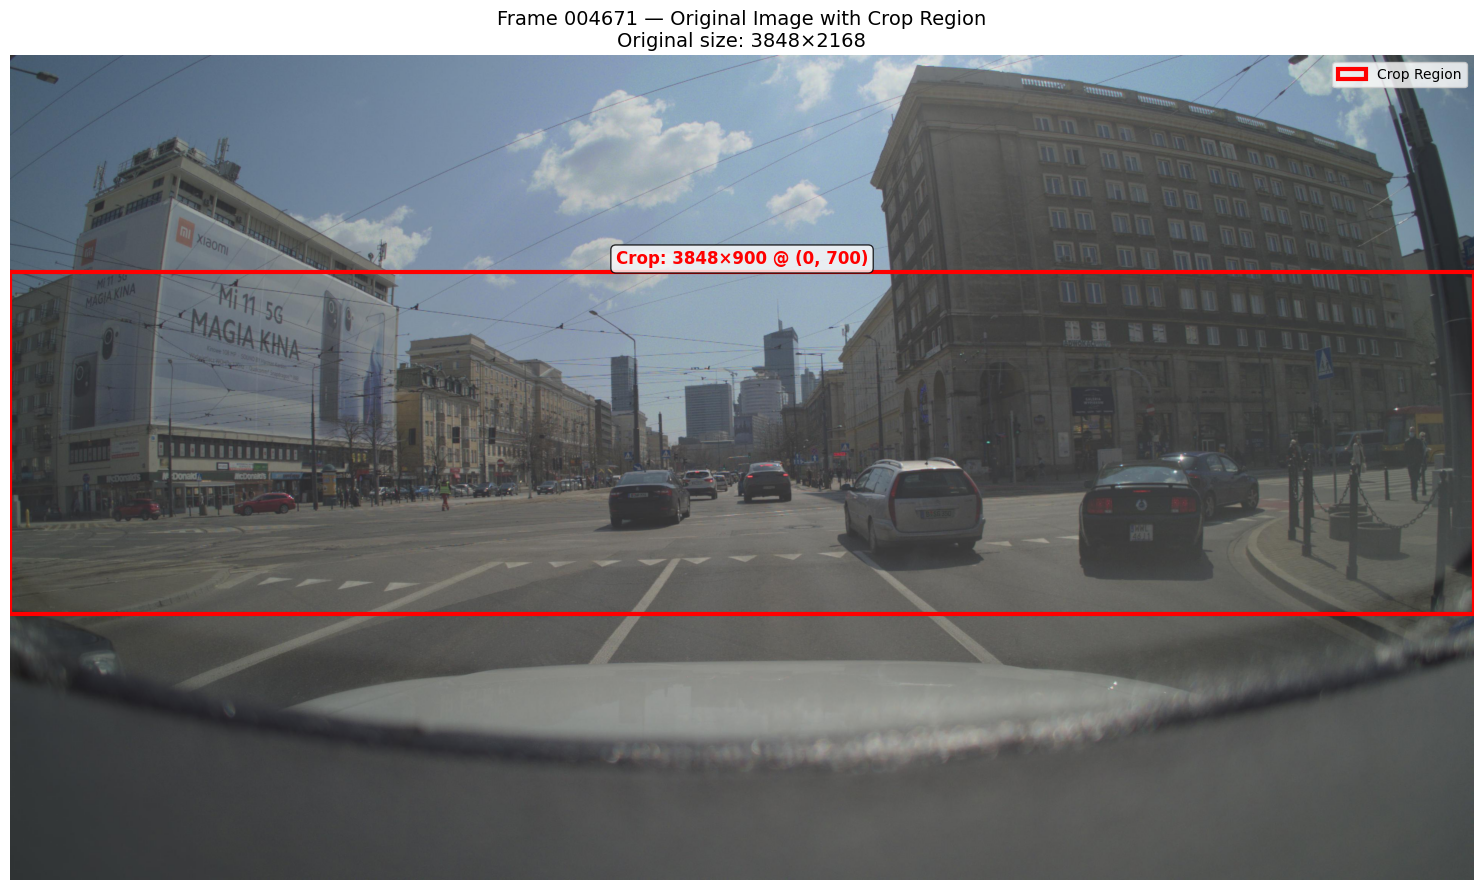

Crop region: left=0, top=700, width=3848, height=900
Crop region in original coordinates: (0, 700) to (3848, 1600)
Original image size: 3848×2168
Cropped region size: 3848×900


In [ ]:
# Visualize the crop region on the original image
# Crop rectangle parameters (in original image coordinates):
#x-coordinate where the crop starts
crop_left = 0
#y-coordinate where the crop starts
crop_top = 700
#width of the crop
crop_width = 3848
#height of the crop
crop_height = 900

"""# Load the original image
frame_id = "000000"
ORIGINAL_first_frame_dir = ORIGINAL_ZOD_ROOT / frame_id
ORIGINAL_DNAT_DIR = ORIGINAL_first_frame_dir / "camera_front_dnat"
original_dnat_files = list(ORIGINAL_DNAT_DIR.glob("*.jpg"))
original_img = Image.open(original_dnat_files[0])"""

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

# Display the original image
ax.imshow(original_img)

# Create rectangle patch for the crop region
# Rectangle parameters: (left, bottom, width, height)
# Note: matplotlib uses bottom-left corner, but images use top-left
# So we need: (left, top from bottom, width, height)
# top from bottom = image_height - top - height
img_height = original_img.size[1]  # PIL uses (width, height)
rect_bottom = img_height - crop_top - crop_height

crop_rect = patches.Rectangle(
    (crop_left, rect_bottom),
    crop_width,
    crop_height,
    linewidth=3,
    edgecolor='red',
    facecolor='none',
    label='Crop Region'
)

ax.add_patch(crop_rect)

# Add text annotation
ax.text(
    crop_left + crop_width/2,
    rect_bottom - 20,
    f'Crop: {crop_width}×{crop_height} @ ({crop_left}, {crop_top})',
    color='red',
    fontsize=12,
    weight='bold',
    ha='center',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

ax.set_title(f"Frame {frame_id} — Original Image with Crop Region\nOriginal size: {original_img.size[0]}×{original_img.size[1]}", fontsize=14)
ax.axis("off")
ax.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()


print(f"Crop region: left={crop_left}, top={crop_top}, width={crop_width}, height={crop_height}")
print(f"Crop region in original coordinates: ({crop_left}, {crop_top}) to ({crop_left + crop_width}, {crop_top + crop_height})")
print(f"Original image size: {original_img.size[0]}×{original_img.size[1]}")
print(f"Cropped region size: {crop_width}×{crop_height}")







## Prediction task for camera-only baseline

- Option A: Binary pedestrian presence likely too simple... Likely highly imbalanced (mostly 1s). Not very informative in dense urban scenes.
- Option B: Pedestrian count (regression or classification)
    - Much richer signal
    - Still avoids geometry headaches
- Option C: Thresholded presence (“crowdedness”)
    - ex: 0: none, 1: few (1–5), 2: many (6–15), 3: crowded (16+). 

- to make a decision here, we'd like some global statistics on pedestrian counts across all frames.

In [22]:
#Pedestrian counts per frame:
counts = []

# Get all frame directories (e.g. "000000", "000001", ...)
frame_dirs = sorted([p for p in DATA_ROOT.iterdir() if p.is_dir()])

total_frames = len(frame_dirs)
print("Total number of frames:", total_frames)

for frame_dir in frame_dirs:
    ann_path = frame_dir / "annotations" / "object_detection.json"
    
    # Skip frames without annotations (safety)
    if not ann_path.exists():
        continue
    
    obj_det = read_json(ann_path)
    
    # Count pedestrians in this frame
    num_peds = sum(
        obj["properties"].get("class") == "Pedestrian"
        for obj in obj_det
    )
    
    counts.append(num_peds)

print("Frames processed:", len(counts))


Total number of frames: 100000
Frames processed: 100000


In [24]:
counts_np = np.array(counts)

print("Pedestrian count statistics:")
print("  Min:", counts_np.min())
print("  Max:", counts_np.max())
print("  Mean:", counts_np.mean())
print("  Median:", np.median(counts_np))

num_zero = np.sum(counts_np == 0)
print("Frames with ZERO pedestrians:", num_zero)
print("Fraction with ZERO pedestrians:", num_zero / len(counts_np))


Pedestrian count statistics:
  Min: 0
  Max: 137
  Mean: 3.59177
  Median: 1.0
Frames with ZERO pedestrians: 41013
Fraction with ZERO pedestrians: 0.41013


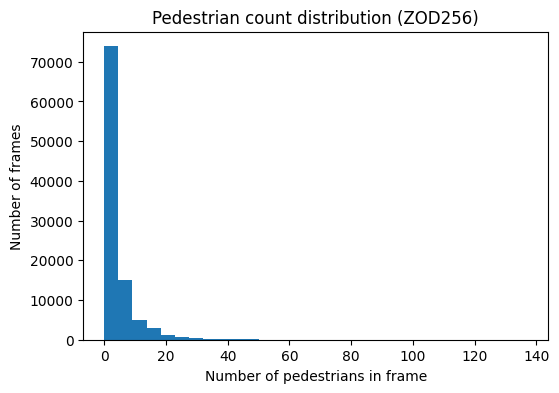

In [25]:
# Pedestrian count distribution:
plt.figure(figsize=(6, 4))
plt.hist(counts_np, bins=30)
plt.xlabel("Number of pedestrians in frame")
plt.ylabel("Number of frames")
plt.title("Pedestrian count distribution (ZOD256)")
plt.show()


In [26]:
def bin_count(n):
    if n == 0:
        return "0"
    elif n <= 5:
        return "1–5"
    elif n <= 15:
        return "6–15"
    else:
        return "16+"

binned = Counter(bin_count(n) for n in counts_np)
print("Binned pedestrian counts:")
for k, v in binned.items():
    print(f"  {k}: {v}")


Binned pedestrian counts:
  16+: 4525
  6–15: 17181
  1–5: 37281
  0: 41013


### Observations:
- Pedestrian presence is not trivial. 
    - ~41% of frames have zero pedestrians
    - ~59% have at least one pedestrian
    → well balanced for a presence task.
- There is a strong long tail:
    - Some frames have very large crowds (up to 100+)
    - Raw regression on counts would be noisy and unstable
- bins are surprisingly well balanced:
    - No bin dominates completely
    - Even 16+ has ~4.5% of data → enough to learn from

OVERALL ASSESSMENT
- Full 2D detection:
    - Requires geometry alignment
    - Heavy engineering
    - Not necessary for research question

- Raw pedestrian count regression:
    - Highly skewed
    - Sensitive to annotation noise
    - Harder to interpret
    → Possible, but not ideal

- Binary pedestrian presence: 
    - balanced, valid choice. 

- Binned pedestrian count (0 | 1–5 | 6–15 | 16+):
    - semantically meaningful (“none”, “few”, “many”, “crowded”)
    - robust to annotation noise
    - well balanced enough to train
    - Uses annotation density information
    - far richer than binary presence
    - Likely best choice. 

- 0 pedestrians → background-dominant scenes
- 1–5 → isolated interactions
- 6–15 → dense urban traffic
- 16+ → crowd scenes, occlusions, clutter


We frame pedestrian perception as a frame-level classification problem, predicting binned pedestrian counts (0, 1–5, 6–15, 16+).

In [ ]:
### CREATE BINNED PEDESTRIAN COUNT LABELS
label_per_frame = {}

for frame_dir in frame_dirs:
    frame_id = frame_dir.name  # e.g. "000000"
    obj_det = read_json(frame_dir / "annotations" / "object_detection.json")
    num_peds = sum(obj["properties"].get("class") == "Pedestrian" for obj in obj_det)
    label_per_frame[frame_id] = bin_count(num_peds)

# --> during training:
y = label_per_frame[frame_id]


## Weather conditions analysis:

In [ ]:
weather_values = []

# Get all frame IDs
frame_ids = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])

total_frames = len(frame_ids)

for fid in frame_ids:
    meta = read_json(DATA_ROOT / fid / "metadata.json")
    weather_values.append(meta.get("scraped_weather", None))

# Count weather occurrences
weather_counts = Counter(weather_values)

print(f"Total frames scanned: {total_frames}")
print("Weather distribution:")

for w, cnt in weather_counts.most_common():
    percentage = 100.0 * cnt / total_frames
    print(f" - {w}: {cnt} ({percentage:.2f}%)")


Total frames scanned: 100000
Weather distribution:
 - partly-cloudy-day: 29153 (29.15%)
 - cloudy: 18991 (18.99%)
 - clear-day: 16441 (16.44%)
 - rain: 15716 (15.72%)
 - partly-cloudy-night: 11124 (11.12%)
 - clear-night: 3999 (4.00%)
 - fog: 2117 (2.12%)
 - snow: 1972 (1.97%)
 - wind: 487 (0.49%)


### Pedestrian bounding-box size distribution
- measure of distribution of pedestrian distance across frames dataset

In [ ]:
# load object_detection.json for one frame (000000)
obj_det_path = first_frame_dir / "annotations" / "object_detection.json"
obj_det = read_json(obj_det_path)   # list of dicts

# find the first pedestrian object ---
ped_obj = None
for obj in obj_det:
    if obj["properties"].get("class") == "Pedestrian":
        ped_obj = obj
        break

print("Found pedestrian:", ped_obj is not None)

# extract the 4 bbox corner points
corners = ped_obj["geometry"]["coordinates"]
print("Corners (4 points):", corners)

# compute xmin/xmax/ymin/ymax ---
xs = [p[0] for p in corners]
ys = [p[1] for p in corners]

xmin, xmax = min(xs), max(xs)
ymin, ymax = min(ys), max(ys)

width  = xmax - xmin
height = ymax - ymin

print("xmin, ymin, xmax, ymax:", xmin, ymin, xmax, ymax)
print("width, height:", width, height)


Found pedestrian: True
Corners (4 points): [[1610.16, 1102.42], [1615.43, 1112.06], [1610.85, 1132.92], [1604.43, 1112.06]]
xmin, ymin, xmax, ymax: 1604.43 1102.42 1615.43 1132.92
width, height: 11.0 30.5


### Pedestrian occlusion distribution

In [ ]:
# Goal: compute a dataset-level "occlusion distribution" for Pedestrian objects
#
# We will scan ALL frames under DATA_ROOT, load each frame's object_detection.json,
# filter to objects with properties["class"] == "Pedestrian", then count how often
# each occlusion_ratio value occurs.
#
# Why do this?
# - It tells us how "hard" the pedestrian labels are (occluded pedestrians are harder).
# - It helps decide whether to include/exclude ambiguous ("unclear") annotations.



# ----------------------------
# Helper: identify pedestrians
# ----------------------------
def is_pedestrian(obj):
    """Return True if this annotation is a Pedestrian object."""
    return obj.get("properties", {}).get("class") == "Pedestrian"

# ----------------------------
# Scan frames and collect occlusion stats
# ----------------------------
occ_all = Counter()          # occlusion counts for ALL pedestrians (including unclear)
occ_clear = Counter()        # occlusion counts for pedestrians with unclear == False
missing_occ_all = 0          # count pedestrians with missing occlusion_ratio field
missing_occ_clear = 0

num_frames_seen = 0
num_frames_missing_ann = 0

num_peds_all = 0
num_peds_clear = 0

# List all frame directories (e.g., 000000, 000001, ...)
frame_dirs = sorted([p for p in DATA_ROOT.iterdir() if p.is_dir()])
print("Total frame folders found:", len(frame_dirs))

for frame_dir in frame_dirs:
    ann_path = frame_dir / "annotations" / "object_detection.json"

    # If a frame doesn't have annotations, skip it (but keep count)
    if not ann_path.exists():
        num_frames_missing_ann += 1
        continue

    num_frames_seen += 1

    # Load annotation list (each element is one object dict)
    obj_det = read_json(ann_path)

    # Filter only pedestrian objects
    peds = [obj for obj in obj_det if is_pedestrian(obj)]

    for obj in peds:
        props = obj.get("properties", {})

        # ---- All pedestrians ----
        num_peds_all += 1
        occ = props.get("occlusion_ratio", None)
        if occ is None:
            missing_occ_all += 1
            occ_all["(missing)"] += 1
        else:
            occ_all[str(occ)] += 1  # cast to str so keys are consistent

        # ---- "Clear" pedestrians (unclear == False) ----
        # If unclear field is missing, .get(..., False) treats it as False
        # (i.e., we assume it's not unclear unless explicitly True)
        is_unclear = props.get("unclear", False)
        if not is_unclear:
            num_peds_clear += 1
            occ_c = props.get("occlusion_ratio", None)
            if occ_c is None:
                missing_occ_clear += 1
                occ_clear["(missing)"] += 1
            else:
                occ_clear[str(occ_c)] += 1

print("\nFrames processed (with annotations):", num_frames_seen)
print("Frames missing object_detection.json:", num_frames_missing_ann)

print("\nTotal pedestrian instances (all):", num_peds_all)
print("Total pedestrian instances (unclear==False):", num_peds_clear)

# ----------------------------
# print results (counts + percentages)
# ----------------------------
def print_counter_as_table(counter, total, title):
    print("\n" + title)
    print("-" * len(title))
    # Sort keys so output is stable/readable
    for k in sorted(counter.keys()):
        v = counter[k]
        pct = (v / total) * 100 if total > 0 else 0.0
        print(f"{k:12s}  {v:8d}  ({pct:6.2f}%)")

print_counter_as_table(
    occ_all,
    num_peds_all,
    title="Pedestrian occlusion_ratio distribution (ALL pedestrians)"
)

print_counter_as_table(
    occ_clear,
    num_peds_clear,
    title="Pedestrian occlusion_ratio distribution (ONLY unclear==False pedestrians)"
)

print("\nMissing occlusion_ratio (ALL):", missing_occ_all)
print("Missing occlusion_ratio (unclear==False):", missing_occ_clear)


Total frame folders found: 100000

Frames processed (with annotations): 100000
Frames missing object_detection.json: 0

Total pedestrian instances (all): 359177
Total pedestrian instances (unclear==False): 318582

Pedestrian occlusion_ratio distribution (ALL pedestrians)
---------------------------------------------------------
(missing)        40595  ( 11.30%)
Heavy            50690  ( 14.11%)
Light            93313  ( 25.98%)
Medium           53826  ( 14.99%)
None            100831  ( 28.07%)
VeryHeavy        19922  (  5.55%)

Pedestrian occlusion_ratio distribution (ONLY unclear==False pedestrians)
-------------------------------------------------------------------------
Heavy            50690  ( 15.91%)
Light            93313  ( 29.29%)
Medium           53826  ( 16.90%)
None            100831  ( 31.65%)
VeryHeavy        19922  (  6.25%)

Missing occlusion_ratio (ALL): 40595
Missing occlusion_ratio (unclear==False): 0


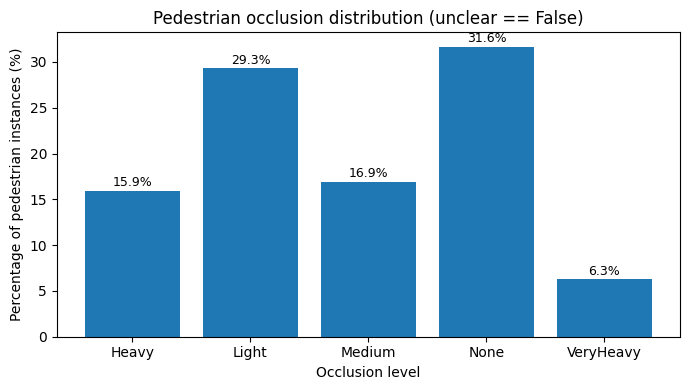

In [30]:
# Use the "clear" pedestrians only (unclear == False)
labels = []
counts = []

for k in sorted(occ_clear.keys()):
    labels.append(k)
    counts.append(occ_clear[k])

total = sum(counts)
percentages = [100 * c / total for c in counts]

plt.figure(figsize=(7, 4))
plt.bar(labels, percentages)
plt.ylabel("Percentage of pedestrian instances (%)")
plt.xlabel("Occlusion level")
plt.title("Pedestrian occlusion distribution (unclear == False)")

# Add percentage labels on top of bars
for i, pct in enumerate(percentages):
    plt.text(i, pct + 0.5, f"{pct:.1f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()


In [32]:
# Explicitly verify relationship between 'unclear' and 'occlusion_ratio'

num_unclear_peds = 0
num_unclear_with_occ = 0

for frame_dir in frame_dirs:
    ann_path = frame_dir / "annotations" / "object_detection.json"
    obj_det = read_json(ann_path)

    for obj in obj_det:
        props = obj.get("properties", {})
        if props.get("class") != "Pedestrian":
            continue

        if props.get("unclear", False):
            num_unclear_peds += 1
            if props.get("occlusion_ratio") is not None:
                num_unclear_with_occ += 1

print("Total unclear pedestrian instances:", num_unclear_peds)
print("Unclear pedestrians WITH occlusion label:", num_unclear_with_occ)


Total unclear pedestrian instances: 40595
Unclear pedestrians WITH occlusion label: 0


Each pedestrian instance in ZOD is annotated with a categorical occlusion level (None, Light, Medium, Heavy, VeryHeavy). Above we plot the dataset-level distribution of these occlusion levels for pedestrian annotations. 

In the ZOD256 split used in this work, all pedestrian annotations marked as unclear lack an occlusion label, whereas all clear pedestrian annotations include one. We therefore exclude annotations marked as unclear from the overall occlusion distribution.

- 89% of total pedestrian instances are marked unclear == False.
- Unclear pedestrians ≈ 11% of instances --> including unclear pedestrians is important for robustness. Excluding them would bias toward easy cases. 
- Every unclear pedestrian lacks an occlusion label
- Every clear pedestrian has an occlusion label


Across 100 000 frames, the dataset contains 359 177 pedestrian instances, with approximately 89% marked as clear annotations. Pedestrian occlusion is prevalent, with nearly 40% of pedestrian instances exhibiting medium-to-very heavy occlusion. Rather than filtering such cases, we treat occlusion as an inherent property of real-world urban perception. We frame pedestrian perception as a frame-level classification task, predicting binned pedestrian counts per frame.